In [37]:
#Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score

# Tree-Based Models: Regression Trees

In this notebook we continue our discussion of regression models, but we deviate away from the usual *linear regression model*. There are many, many classes of model and we won't cover nearly all of them in our course. A second class of model which can be used for regression is called the *regression tree*. We'll discuss it here.

Tree-based models are quite popular because they mimic a human's decision-making process (*If this, then that...*). They are very easily understood, even by non-experts, because they can be made quite visual -- in fact, you already know exactly what a tree-based model looks like, even though we haven't discussed them -- they are just *decision trees*. 

In this notebook, we'll continue to work through our insurance rate-setting application. The data will be the same data you've been using over the last three weeks, but rather than build a linear regression model, we'll build a decision tree regressor.

## About tree-based models

As mentioned, tree-based models are quite popular because they are intuitive. Of all the classes of models, these are the ones that non-experts will like most because they can be understood without any significant background or explanation. That being said, tree-based models can be tricky to use correctly.

Let's start with the assumptions we are making when we choose to utilize a decision tree.

+ Trees assume that observations can be segmented into relatively homogeneous regions, in which oservations in a similar location all exhibit a similar response.

    + The idea here is that trees basically bin similar observations together. Training a tree determines what it means for observations to be similar.

+ Trees assume that we can determine which observations are similar to one another by asking a series of simple yes/no questions (ie. *Is `age` greater than 55?*).

    + This assumption results in the feature space being cut into [high dimentional]-"rectangular" regions, where each cut made is perpendicular to one of the feature axes. In 2-dimensions (one feature, one response), this is quite easy to understand -- see the image that follows.

Below you can see two regression trees fit on a randomly generated set of data (don't worry about the code, just take a look at the pictures that result from it). One of the trees is unconstrained -- you can see that the unconstrained model overfits the data -- the other tree is constrained to a maximum depth of three. This means that along each branch, we ask at most three questions about the features before making a prediction. You'll notice that there are $2^3=8$ predicted levels of the response (denoted by horizontal red line segments) in the plots.

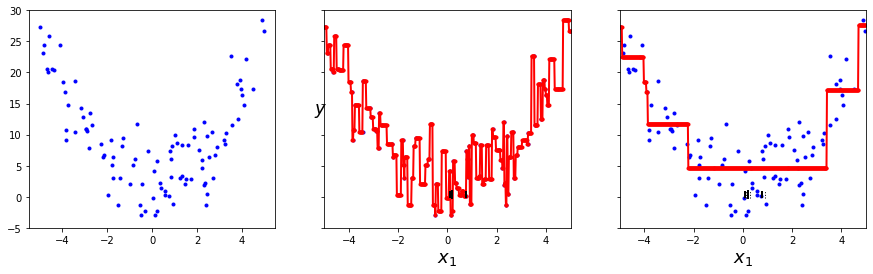

In [38]:
X = 10*np.random.rand(100, 1) - 5
y = X**2 + 1 + 4*np.random.randn(100, 1)

tree_reg_NoLeash = DecisionTreeRegressor()
tree_reg_Constrained = DecisionTreeRegressor(max_depth = 3)

tree_reg_NoLeash.fit(X, y)
tree_reg_Constrained.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[-5, 5, -5, 30], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=3, figsize=(15, 4), sharey=True)
plt.sca(axes[0])
plt.plot(X, y, "b.")

plt.sca(axes[1])
plot_regression_predictions(tree_reg_NoLeash, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
#plt.text(0.21, 0.65, "Depth=0", fontsize=15)
#plt.text(0.01, 0.2, "Depth=1", fontsize=13)
#plt.text(0.65, 0.8, "Depth=1", fontsize=13)
#plt.legend(loc="upper center", fontsize=18)
#plt.title("max_depth=2", fontsize=14)

plt.sca(axes[2])
plot_regression_predictions(tree_reg_Constrained, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
#plt.text(0.3, 0.5, "Depth=2", fontsize=13)
#plt.title("max_depth=3", fontsize=14)

#save_fig("tree_regression_plot")
plt.show()

Can you tell what the splitting boundaries and corresponding questions are? In the plots above each decision boundary and question asked corresponds to one of the red vertical line segments in the plots. The regression tree corresponding to the rightmost plot appears below -- does it match what you expected?. 

When reading the plot, non-leaf nodes (the nodes that have arrows coming *out* of them) include four rows of text. The first row lists the question used to split the node into its two children. The third line gives the number of training observations contained in that node. The fourth line gives the predicted response for observations falling in this node (it is the mean resonse over all observations in the bucket). The second line lists the *mean square error* (MSE) corresponding to the model predictions if this node's mean were used as the predicted value. The leaf nodes (nodes with no children extending from them) are the nodes corresponding to model predictions. These nodes don't split any further, so they have no row corresponding to a splitting question. All other rows of text have the same interpretations though. Regarding nodes that split, an answer of "yes" to the splitting question moves down to the child on the left while an answer of no moves down to the child on the right.

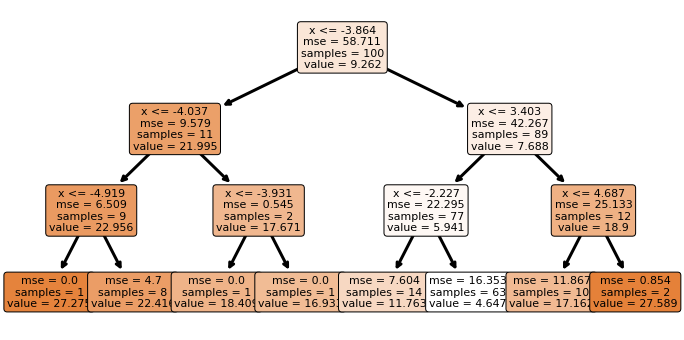

In [39]:
plt.figure(figsize = (12, 6))
out = plot_tree(tree_reg_Constrained, feature_names = ["x"], filled = True, rounded = True, fontsize = 11)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)

Before we jump to constructing our first decision tree regressor, it is worth noting explicitly that decision trees are enticed to overfit the training data. We need to use constraints (sometimes called *regularization*) to prevent this overfitting -- for example, in the code above, the second model was constrained by mandating a maximum depth of 3 rather than allowing the tree to grow without bound (as in the `NoLeash` tree).

## Constructing and using a decision tree regressor to predict insurance claims

Now that we know a bit more about decision tree models, let's actually build and use one. We'll start with a quick review of our dataset and the goal for our predictive model.

### About our data

- Our simple dataset contains a few attributes for each person such as 
- Age, Sex, BMI, Children, Smoker, Region and their charges

### Goal
- To use this info to predict charges for new customers
  - An insurance company can use this information to inform *rate-setting*
  
## Preliminaries

Remember that we'll always start by building a *training*, *test*, and *safe* set. We'll do that and just print out the head of the *training* data.

In [40]:
file_name = "https://raw.githubusercontent.com/rajeevratan84/datascienceforbusiness/master/insurance.csv"
insurance = pd.read_csv(file_name)

#Get dummy variables
insurance = pd.get_dummies(insurance, columns = ["sex", "smoker", "region"], drop_first = True)

#Split to training, test, and safe data
X = insurance.drop(["charges"], axis = 1)
y = insurance["charges"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.25, random_state = 42)
X_safe, X_test, y_safe, y_test = train_test_split(X_temp, y_temp, test_size = 0.6, random_state = 42)

X_train.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
693,24,23.655,0,1,0,1,0,0
1297,28,26.510,2,0,0,0,1,0
634,51,39.700,1,1,0,0,0,1
1022,47,36.080,1,1,1,0,1,0
178,46,28.900,2,0,0,0,0,1


Okay, now that we have our data processed and split, we are ready to fit our decision tree regressor. We'll fit an unconstrained regression tree and then plot its first three levels. The text printed out before the plot renders is the decision tree in text form -- it shows us information about each node, including the question used to split the node.

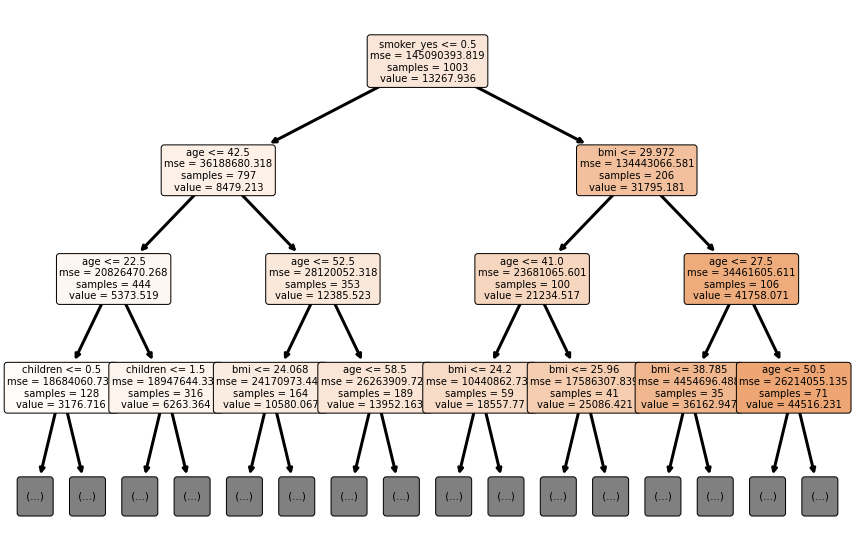

In [41]:
tree_reg = DecisionTreeRegressor()

tree_reg.fit(X_train, y_train)

plt.figure(figsize = (15, 10))
out = plot_tree(tree_reg, feature_names = X_train.columns, filled = True, rounded = True, fontsize = 10, max_depth = 3)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)

Now that we have a tree, let's see how it performs on the training and test data. We'll just work with the $\tt{RMSE}$ metric here.

In [43]:
tree1_trainRMSE = (((y_train - tree_reg.predict(X_train))**2).mean())**0.5
tree1_testRMSE = (((y_test - tree_reg.predict(X_test))**2).mean())**0.5

print("The training RMSE for our unconstrained tree is: $", tree1_trainRMSE, sep = "")
print("The test RMSE for our unconstrained tree is: $", tree1_testRMSE, sep = "")

#Uncomment below to see Cross-Validation Results
X_trainCV = pd.concat([X_train, X_test])
y_trainCV = pd.concat([y_train, y_test])
tree_reg_cv = DecisionTreeRegressor()
cv_results = cross_val_score(tree_reg_cv, X_trainCV, y_trainCV, cv = 10, scoring = "neg_root_mean_squared_error")
print("Using an unconstrained tree:")
print("\t RMSE on folds: ", -1*cv_results)
print("\tCross validation RMSE estimate: ", (-1*cv_results).mean())

The training RMSE for our unconstrained tree is: $427.37357318969015
The test RMSE for our unconstrained tree is: $6547.87501995688
Using an unconstrained tree:
	 RMSE on folds:  [7588.41719366 5659.96490195 7664.55244673 6606.03017321 6455.40048313
 7487.49890375 7759.51372969 6483.0387179  6100.40250306 5621.67486662]
	Cross validation RMSE estimate:  6742.649391969086


What a difference between our training and test errors! This tree is way overfit -- did you expect that? I hope so. Additionally, if you remember the end of last week, our best model had an estimated prediction error of about \\$6,137 and here we are significantly higher than that. It looks like our tree is not doing as good a job. At this point, there are two possible explanations -- (i) our linear regressor is just better-suited to predicting the `charges` given our features, or (ii) we just haven't used an optimal tree. Let's see if we can build a better tree.

### An Aside: Hyperparameters and Model Tuning

In statistical modeling, a parameter for a model is a value which is optimized by the model fitting procedure. A *hyperparameter* is a setting which is determined prior to model fitting. For example, setting `max_depth = 3` determines prior to fitting the decision tree regressor that the maximum number of splits along any branch is 3. This means that `max_depth` is a hyperparameter.

It isn't very efficient to just randomly guess to find the "best" maximum depth or the best value for any of the other hyperparameters available when fitting decision trees. You can see the hyperparameters available to decision tree regressors in `sklearn` from the [documentation of `DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). Since the model fitting procedure doesn't optimize hyperparameters, we have two choices. We can either choose the hyperparameters manually (which we've already said is sub-optimal) or we can try to adapt the model fitting procedure so that multiple hyperparameter combinations are tried, and the best combination is selected. How do we do this? Keep calm and cross-validate. Remember how the cross-validation process helped us decide whether to use the straight-line linear regression model, the model that included curvature associated with the `age` variable, or the model that allowed for lots of flexibility through the third-degree polynomial terms? In a sense, those curvature and interaction terms were hyperparameters too -- cross validation gave us error estimates associated with each model and we chose the one with the best cross-validation error estimate. We'll use the same strategy here.

Before we do this, it is worth mentioning the complexity we are about to run up against. Remember that 10-fold cross-validation trains and validates a model 10 separate times. If we tune the `max_depth` hyperparameter considering that `max_depth` could be any of the values in the list `[2, 3, 4, 5, 6, 8, 10]`, we will be training 70 models (ten models for each choice of max depth). Now what if we also want to tune the `max_leaf_nodes` and `min_samples_split` parameters -- each with just three possibilities. All of a sudden we'll be fitting $10\times 7\times 3 \times 3~=~630$ models! The run-time here is going to grow exponentially, so keep this in mind when deciding what hyperparameters to tune and which values to consider. We'll just move forward with tuning the `max_depth` hyperparameter over the list of possibilities `[2, 3, 4, 5, 6, 8, 10]`. 

In [44]:
max_depth = [2, 3, 4, 5, 6, 8, 10]

X_trainCV = pd.concat([X_train, X_test])
y_trainCV = pd.concat([y_train, y_test])

for depth in max_depth:
    tree_reg = DecisionTreeRegressor(max_depth = depth)
    
    cv_results = cross_val_score(tree_reg, X_trainCV, y_trainCV, cv = 10, scoring = "neg_root_mean_squared_error")
    print("Using max_depth ", depth, ":")
    print("\t RMSE on folds: ", -1*cv_results)
    print("\tCross validation RMSE estimate: ", (-1*cv_results).mean())

Using max_depth  2 :
	 RMSE on folds:  [5264.83374054 4640.08301359 4563.78677902 5092.21206401 5381.98399534
 5388.5943107  5214.81452759 5555.1878812  5045.3925204  5499.16003615]
	Cross validation RMSE estimate:  5164.6048868532025
Using max_depth  3 :
	 RMSE on folds:  [5085.80644768 4107.10157584 3967.85949074 4867.40324508 4780.14262396
 5099.2867218  5147.33136686 5517.63716986 4929.95600421 5206.28111673]
	Cross validation RMSE estimate:  4870.880576277127
Using max_depth  4 :
	 RMSE on folds:  [4854.70858763 3905.67276594 4016.42674872 4654.98868332 4800.98970499
 5208.43601536 5032.20232699 5398.58692776 4754.1132023  4828.5279848 ]
	Cross validation RMSE estimate:  4745.465294780113
Using max_depth  5 :
	 RMSE on folds:  [4624.46209505 3946.84618217 4494.2119904  4741.84491478 4848.69045989
 5123.61391532 5369.62282256 5191.60558293 4808.91483255 4719.71183047]
	Cross validation RMSE estimate:  4786.952462611383
Using max_depth  6 :
	 RMSE on folds:  [4762.48862656 4378.0224

It looks like using a `max_depth` of 4 yielded the best cross-validation error. It looks like we should expect a prediction error of around \\$4,745.47 if we use a decision tree and a max depth of 4. This is already over a \\$1,500 improvement over the linear regression model, and we only tuned one hyperparameter!

Let's crack open the safe and see whether our decision tree with `max_depth` 4 performs as expected on this data which still has yet to be seen by our model.

In [45]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

bestChargesTreeModel = DecisionTreeRegressor(max_depth = 4)

bestChargesTreeModel.fit(X, y)
print("RMSE on Safe Data: ", (((y_safe - bestChargesTreeModel.predict(X_safe))**2).mean())**0.5)

RMSE on Safe Data:  4219.119946497202


Our model performs right in the ball-park of where we expected it would. If our Safe RMSE was not comparable to any of the RMSE metrics we observed during cross-validation for the depth-4 tree, then we should be concerned about the possibility of an overfit model or training and safe data which are note representative of one another.

Let's re-build our decision tree regressor with a max depth of 4, using all of the available data and see what it predicts as the cost to insure our potential new subscriber from last time.

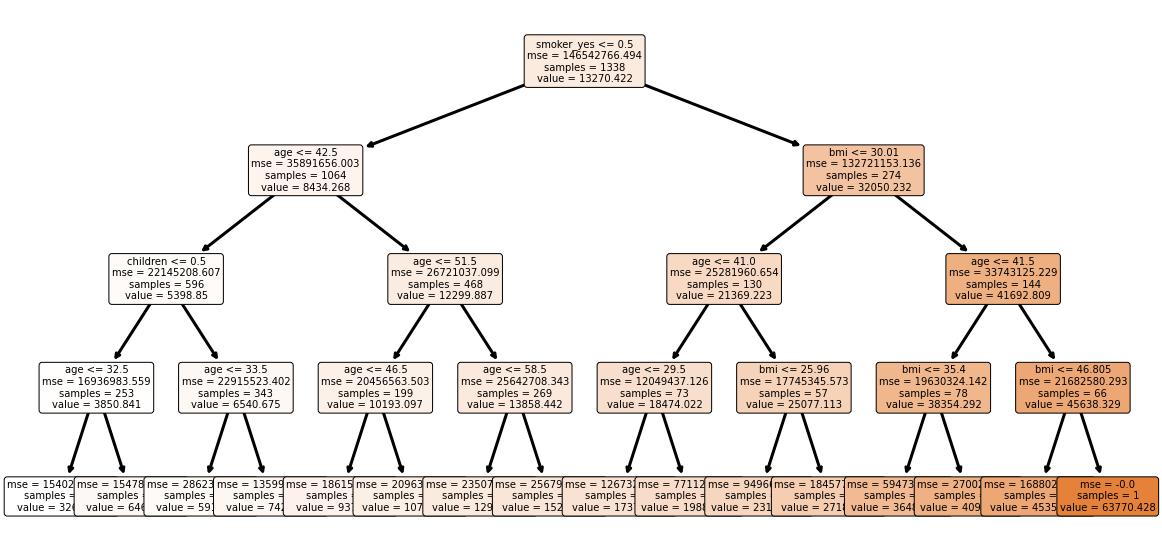

array([7422.3384193])

In [46]:
X = pd.concat([X_train, X_test, X_safe])
y = pd.concat([y_train, y_test, y_safe])

productionChargesTreeModel = DecisionTreeRegressor(max_depth = 4)

productionChargesTreeModel.fit(X, y)

plt.figure(figsize = (20, 10))
out = plot_tree(productionChargesTreeModel, feature_names = X_train.columns, filled = True, rounded = True, fontsize = 10)
for o in out:
    arrow = o.arrow_patch
    if arrow is not None:
        arrow.set_edgecolor('black')
        arrow.set_linewidth(3)
plt.show()

new = {"age" : [34], "bmi" : [28], "children" : [2], "sex_male" : [1], "smoker_yes" : [0], "region_northwest" : [0], "region_southeast" : [0], "region_southwest" : [0]}
new = pd.DataFrame(new)

productionChargesTreeModel.predict(new)

It looks like our new tree-based model predicts a significantly higher cost to insure (about \\$7,422.34) than our linear regressor from last week did. We may have just saved the company from some significant losses!

## Summary

Okay, that's it for now -- you know a second class of model which can be used to predict a numerical response. It won't always be the case that a regression tree outperforms a linear model or vice-versa, so it is important to consider both as options. You've got a second notebook this week that introduces the idea of a *classification tree*. Tree-based models can be employed in both the regression and classification settings. Check out the *12_ClassificationTrees* notebook next.